## Model

In [11]:
using Revise, ReachabilityAnalysis, Plots

We model the bouncing ball as a hybrid automaton with one location and a self-loop. For background see for example [C. Le Guernic's PhD thesis, pp. 79-83](https://tel.archives-ouvertes.fr/tel-00422569v1/document).

Next we define the hybrid model:

In [3]:
function bouncing_ball(; X0 = Hyperrectangle(low=[10.0, 0.0], high=[10.2, 0.0]))

    # "falling" mode with invariant x >= 0
    invariant = HalfSpace([-1.0, 0.0], 0.0)
    flow = @system(z' = [0.0 1.0; 0.0 0.0] * z + [0.0, -9.81], z ∈ invariant)

    # guard x ≤ 0 && v ≤ 0
    guard = HPolyhedron([HalfSpace([1.0, 0.0], 0.0), HalfSpace([0.0, 1.0], 0.0)])

    # reset map v⁺ := -cv
    assignment = ConstrainedLinearMap([1.0 0.0; 0.0 -0.75], guard)

    # initial-value problem
    H = HybridSystem(flow, assignment)
    prob = @ivp(H, z(0) ∈ X0)
    tspan = (0.0, 5.0)

    return prob, tspan
end

bouncing_ball (generic function with 1 method)

## Results

In [186]:
prob, tsp = bouncing_ball();

Let's study the continuous transition first.

In [187]:
prob_cont = IVP(prob.s.modes[1], prob.x0);
sol = solve(prob_cont, T=10.0, alg=GLGM06(δ=0.01));
tspan(sol)

[0, 1.46001]

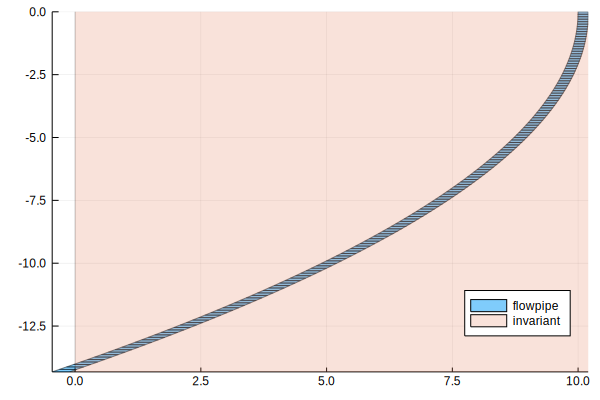

In [188]:
plot(sol, vars=(1, 2), lab="flowpipe")
plot!(stateset(prob_cont), alpha=.2, lab="invariant", legend=:bottomright)

Note that there are only two sets which intersect the guard. Morover, the invariant intersection inside the continuous post has effectively cut the computation until thre is one reach-set whose intersection with the invariant is empty.

Next we consider the discrete transition. We convexify the last two sets.

In [189]:
Zch = overapproximate(CH(set(sol[end-1]), set(sol[end])), Zonotope)

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([-0.14188525000000762, -14.22450000000002], [0.07087725000000006 0.10049049999999937 … -0.0002452500000000024 -0.0002452500000000024; 0.04905 0.0 … 0.0 0.0])

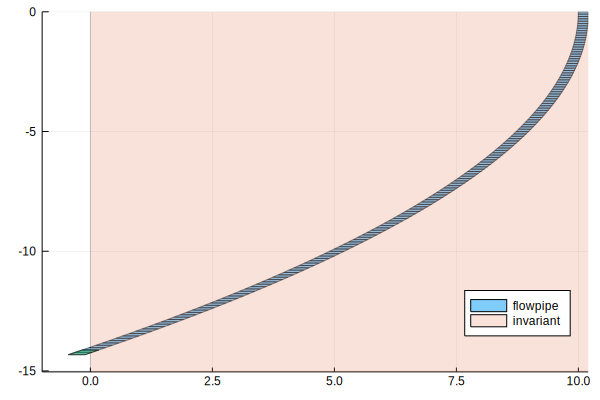

In [190]:
plot!(Zch)

In [191]:
X = Convexify(sol[end-1:end]);
typeof(X)

ReachSet{Float64,ConvexHullArray{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}}}}

In [192]:
using ReachabilityAnalysis: apply

R = prob.s.resetmaps[1].A
W = ZeroSet(size(R, 1))
G = stateset(prob.s.resetmaps[1])
I⁻ = stateset(prob.s.modes[1])
I⁺ = I⁻;

tr = DiscreteTransition(R, W, G, I⁻, I⁺);

In [193]:
Zch_out = apply(tr, Zch, ReachabilityAnalysis.HRepIntersection());

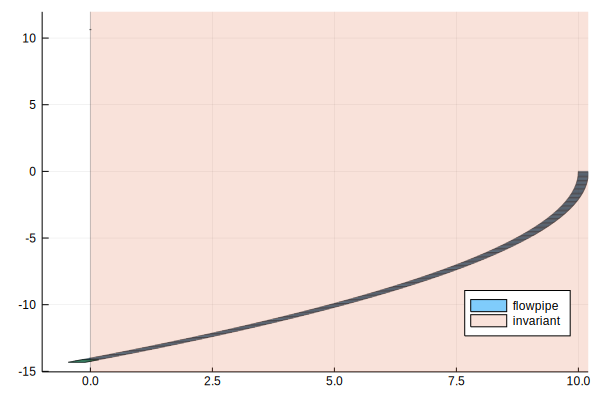

In [194]:
plot!(Zch_out, lw=2.0)

Now we need an initial set to feed `GLGM06`. The `_convert_or_overapproximate` method can take care of that conversion to a zonotope.

In [195]:
prob_cont = IVP(prob.s.modes[1], Zch_out);
sol2 = solve(prob_cont, T=10.0 - tstart(sol[end-1]), alg=GLGM06(δ=0.01));
sol2 = shift(sol2.F, tstart(sol[end-1]))
sol_tot = HybridFlowpipe([sol.F, sol2]);
tspan(sol2)

[1.43999, 3.65]

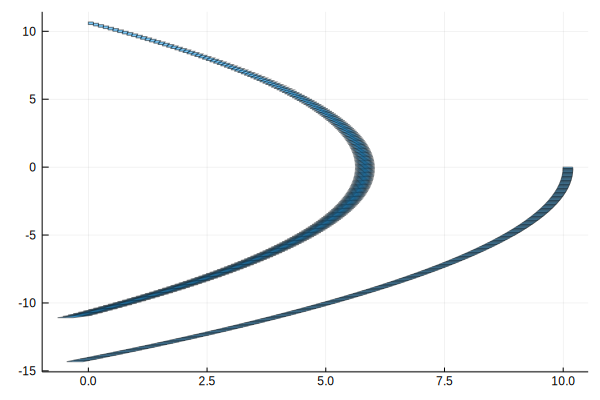

In [196]:
plot(sol_tot, vars=(1, 2))

## Discussion

In [ ]:
function bouncing_ball()
    # automaton structure
    automaton = LightAutomaton(1)

    # mode 1
    A = [0.0 1.0; 0.0 0.0]
    B = reshape([0.0, -1.0], (2, 1))
    U = Singleton([1.0])
    inv = HalfSpace([-1.0, 0.0], 0.0) # x >= 0
    m1 = ConstrainedLinearControlContinuousSystem(A, B, inv, ConstantInput(U))

    # modes
    modes = [m1]

    # transition from m1 to m1 (self-loop)
    add_transition!(automaton, 1, 1, 1)
    A = [1.0 0.0; 0.0 -0.75]
    guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                         HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                         HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0
    t1 = ConstrainedLinearMap(A, guard)

    # transition annotations
    resetmaps = [t1]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in mode 1
    X0 = Hyperrectangle(low=[10.0, 0.0], high=[10.2, 0.0])
    initial_condition = [(1, X0)]

    system = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>5.0,
                      :plot_vars=>[1, 2], :max_jumps=>1, :verbosity=>1)

    return (system, options)
end

In [ ]:
# invariant: x >= 0
function bouncing_ball(; X0 = (10 .. 10.2) × (-0.1 .. 0.1),  # set of initial conditions
                         max_jumps=1,
                         Δt=(0.0, 10.0), # sufficiently high, for demonstration
                         alg=GLGM06(δ=0.01)) # continuous post-operator
    
    # define the model
    invariant = HalfSpace([-1.0, 0.0], 0.0)
    falling = @system(z' = [0.0 1.0; 0.0 0.0] * z + [0.0, -g], z ∈ invariant)

    guard = HPolyhedron([HalfSpace([1.0, 0.0], 0.0),   # x ≤ 0
                         HalfSpace([0.0, 1.0], 0.0)]) # v ≤ 0

    assignment = ConstrainedLinearMap([1.0 0.0; 0.0 -c], guard)

    N = Float64
    ZT = Zonotope{N, Vector{N}, Matrix{N}}
    RT = ReachSet{N, ZT}
    out = Vector{ShiftedFlowpipe{Flowpipe{N, RT, Vector{RT}}, N}}()
    t0 = 0.0

    for k in 1 : max_jumps + 1

        # initial-value problem
        prob = @ivp(falling, x(0) ∈ X0)

        # solve it; the time span should be sufficiently high
        sol = solve(prob, tspan=Δt, alg=alg)

        # detect reach-sets whose intersection with the guard is non-empty (of course in principle
        # all sets should be checked)
        aux = findfirst([_is_intersection_empty(set(X), guard) for X in sol[end:-1:1]])

        # push solution (to simplify we don't care about pushing parts of sets wich are removed)
        push!(out, ShiftedFlowpipe(sol.F[1:(length(sol.F) - aux + 2)], t0))
        
        # convexify and convert to vrep
        C = ReachabilityAnalysis.Convexify(sol[end-aux+1:end])
        Cvertex = convex_hull(vcat([vertices_list(Z) for Z in LazySets.array(set(C))]...)) |> VPolygon
        t0 += tstart(C)
        
        # compute concrete intersectin with the guard
        I = intersection(Cvertex, guard)

        # compute concrete intersection with the invariant
        X = intersection(I, invariant)

        # apply the reset map and get the new initial set
        X0 = apply(assignment, X)
    end
    return HybridFlowpipe(out)
end

-----

**References:**

- [JuliaReach: a toolbox for set-based reachability](https://arxiv.org/abs/1901.10736) -- describes the approach for hybrid systems reachability described in this notebook
- [Reachability Analysis for Hybrid Systems using Support Functions](http://www-ljk.imag.fr/membres/Antoine.Girard/Publications/cav2009.pdf) -- nice high-level description of reachability analysis for a hybrid system
- A more complete list of references: https://juliareach.github.io/ReachabilityAnalysis.jl/dev/references/

## Hybrid automaton

In [ ]:
using Revise, ReachabilityAnalysis, Plots

This model has two state variables $z = (x, v)$ where $x$ is position and $v$ is velocity. The equations of motion are

$$
\begin{cases}
x' = v \\
v' = -g
\end{cases}
$$

In [ ]:
const g = 9.8

# falling mode
X = HalfSpace([-1.0, 0.0], 0.0) # invaiant: x >= 0
falling = @system(z' = [0.0 1.0; 0.0 0.0] * z + [0.0, -g], z ∈ X);

We model the bouncing ball as a hybrid automaton with a single mode and a self-loop, with guard 

$$
G : \{(x, y) \in \mathbb{R}^2: (x \leq 0) \cap (v \leq 0) \}
$$

In [ ]:
G = HPolyhedron([HalfSpace([1.0, 0.0], 0.0),   # x ≤ 0
                 HalfSpace([0.0, 1.0], 0.0)]); # v ≤ 0

When the ball bounces in the floor, it looses some energy. We model this with an assignment:

$$
\begin{cases}
x := x \\
v := -c v
\end{cases}
$$

where $c > 0$ is some predefined constant; let $c = 0.75$.

In [ ]:
assignment = ConstrainedLinearMap([1.0 0.0; 0.0 -0.75], guard);

## Computing the flowpipe

Now we compute the continuous evolution until the first tim the ball hits the ground:

In [ ]:
# set of initial conditions
X0 = (10 .. 10.2) × (-0.1 .. 0.1)

# initial-value problem
prob = @ivp(falling, x(0) ∈ X0)

# solve it; the time span should be sufficiently high
sol = solve(prob, tspan=(0.0, 10.0), alg=GLGM06(δ=0.05));

In [ ]:
plot(sol, vars=(1, 2), xlab="x", ylab="v")
plot!(sol[end], vars=(1, 2)) # last set

## Computing the discrete succesors

Now we take the convex hull of all those sets which actually intersect the guard.

In [ ]:
using ReachabilityAnalysis: _is_intersection_empty

In [ ]:
findfirst([_is_intersection_empty(set(X), guard) for X in sol[end:-1:1]])

So only the last four sets intersect with the guard.

We take their convex hull and overapproximate it with another zonotope.

What convexify does in the next line is to take the lazy convex hull array of the sets:

In [ ]:
C = ReachabilityAnalysis.Convexify(sol[end-3:end])

In [ ]:
plot(set(C), 1e-3, xlab="x", ylab="v")
plot!([set(R) for R in sol[end-3:end]])

Hence, we know that $C$ contains all trajectories that may take the transition for the time span:

In [ ]:
tspan(C)

Working with $C$ instead of each reach-set has the benefit that the computatinal cost is lower; however, using the convex hull induces an overapproximation.

Let's compute the convex hull exactly using vertices -- important: this is **NOT** the way to do it in general because changing to vrep is expensive; this is only for illustration.. in general we would use support functins ("templates") or polytopic overapproximations following by an overapprox with a zonotope.

In [ ]:
Cvertex = convex_hull(vcat([vertices_list(Z) for Z in LazySets.array(set(C))]...)) |> VPolygon

In [ ]:
plot(Cvertex) # convex hull with vertices is ok

Now we compute the concrete intersection with the guard set:

In [ ]:
I = intersection(Cvertex, G)

In [ ]:
plot!(I, lab="Intersection")

Then we compute the intersection with the invariant,

In [ ]:
invariant = stateset(prob)

In [ ]:
X = intersection(I, invariant)

In [ ]:
# this is just a line as expected
plot(X, lw=2.0)

Now we apply the reset map,

In [ ]:
A = apply(assignment, X)

And finally we compute the intersection with invariant the target location (which is again `invariant`) so we don't need that.

The set $A$ possibly after approximation with a zonotope is used for the next loop. We can pass $A$ diretly to the solver though.

In [ ]:
vertices_list(A)

In [ ]:
# initial-value problem
prob = @ivp(falling, x(0) ∈ A)

# solve it; the time span should be sufficiently high
t0 = tstart(C)
sol2 = solve(prob, tspan=(0.0, 10.0), alg=GLGM06(δ=0.01));
sol2 = ShiftedFlowpipe(sol2.F, t0);

In [ ]:
plot(sol, vars=(1, 2), xlab="x", ylab="v")
plot!(sol2, vars=(1, 2))

## Several jumps

In [ ]:
# invariant: x >= 0
function bouncing_ball(; X0 = (10 .. 10.2) × (-0.1 .. 0.1),  # set of initial conditions
                         max_jumps=1,
                         Δt=(0.0, 10.0), # sufficiently high, for demonstration
                         alg=GLGM06(δ=0.01)) # continuous post-operator
    
    # define the model
    invariant = HalfSpace([-1.0, 0.0], 0.0)
    falling = @system(z' = [0.0 1.0; 0.0 0.0] * z + [0.0, -g], z ∈ invariant)

    guard = HPolyhedron([HalfSpace([1.0, 0.0], 0.0),   # x ≤ 0
                         HalfSpace([0.0, 1.0], 0.0)]) # v ≤ 0

    assignment = ConstrainedLinearMap([1.0 0.0; 0.0 -c], guard)

    N = Float64
    ZT = Zonotope{N, Vector{N}, Matrix{N}}
    RT = ReachSet{N, ZT}
    out = Vector{ShiftedFlowpipe{Flowpipe{N, RT, Vector{RT}}, N}}()
    t0 = 0.0

    for k in 1 : max_jumps + 1

        # initial-value problem
        prob = @ivp(falling, x(0) ∈ X0)

        # solve it; the time span should be sufficiently high
        sol = solve(prob, tspan=Δt, alg=alg)

        # detect reach-sets whose intersection with the guard is non-empty (of course in principle
        # all sets should be checked)
        aux = findfirst([_is_intersection_empty(set(X), guard) for X in sol[end:-1:1]])

        # push solution (to simplify we don't care about pushing parts of sets wich are removed)
        push!(out, ShiftedFlowpipe(sol.F[1:(length(sol.F) - aux + 2)], t0))
        
        # convexify and convert to vrep
        C = ReachabilityAnalysis.Convexify(sol[end-aux+1:end])
        Cvertex = convex_hull(vcat([vertices_list(Z) for Z in LazySets.array(set(C))]...)) |> VPolygon
        t0 += tstart(C)
        
        # compute concrete intersectin with the guard
        I = intersection(Cvertex, guard)

        # compute concrete intersection with the invariant
        X = intersection(I, invariant)

        # apply the reset map and get the new initial set
        X0 = apply(assignment, X)
    end
    return HybridFlowpipe(out)
end

In [ ]:
sol = bouncing_ball(max_jumps=3);

In [ ]:
plot(sol, vars=(1, 2), xlab="x", ylab="v")